## **Exercise: Build a Denoising Convolutional Autoencoder**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### **Dataset Preparation and Preprocessing:**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Paths
data_path = '/content/drive/MyDrive/DevanagariHandwrittenDigitDataset'
train_path = os.path.join(data_path, 'Train')
test_path = os.path.join(data_path, 'Test')

# Load images from directory
def load_images_from_folder(folder, image_size=(32, 32)):
    images = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                try:
                    img = Image.open(img_path).convert('L').resize(image_size)
                    images.append(np.array(img))
                except:
                    print(f"Error loading image: {img_path}")
    return np.array(images)

# Load train and test images
train_images = load_images_from_folder(train_path)
test_images = load_images_from_folder(test_path)

# Combine for larger training dataset
images = np.concatenate((train_images, test_images), axis=0)
images = images.astype('float32') / 255.0  # Normalize
images = np.expand_dims(images, axis=-1)  # Add channel dimension

# Add Gaussian noise
def add_noise(images, noise_factor=0.3):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

noisy_images = add_noise(images)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(noisy_images, images, test_size=0.2, random_state=42)


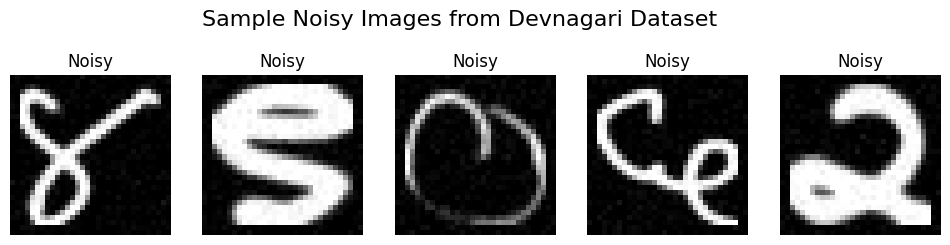

In [ ]:
import matplotlib.pyplot as plt

n = 5  # number of images to display
plt.figure(figsize=(12, 3))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train_noisy[i].reshape(32, 32), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

plt.suptitle("Sample Noisy Images from Devnagari Dataset", fontsize=16)
plt.show()


### **Build the Denoising Convolutional Autoencoder:**

In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoencoder((32, 32, 1))
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

### **Train the Denoising Autoencoder:**

In [ ]:
history = autoencoder.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val, y_val)
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 468ms/step - loss: 0.3821 - val_loss: 0.1510
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 464ms/step - loss: 0.1480 - val_loss: 0.1393
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - loss: 0.1392 - val_loss: 0.1365
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 486ms/step - loss: 0.1355 - val_loss: 0.1337
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 480ms/step - loss: 0.1337 - val_loss: 0.1314
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 482ms/step - loss: 0.1315 - val_loss: 0.1307
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step - loss: 0.1305 - val_loss: 0.1295
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - loss: 0.1299 - val_loss: 0.1289
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 467ms/step - loss: 0.1290 - val_loss: 0.1280
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - loss: 0.1285 - val_loss: 0.1276


### **Evaluate and Visualize the Results:**

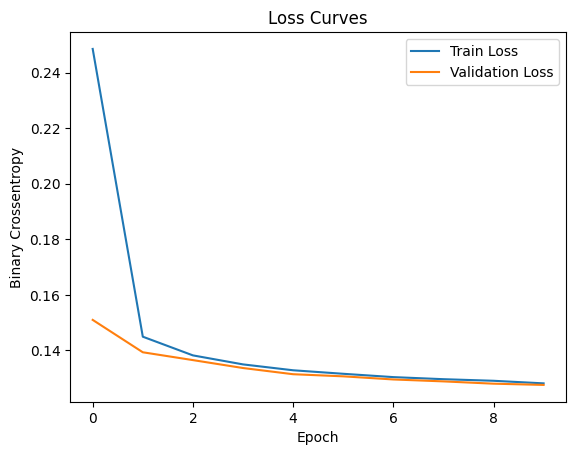

In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.show()

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step


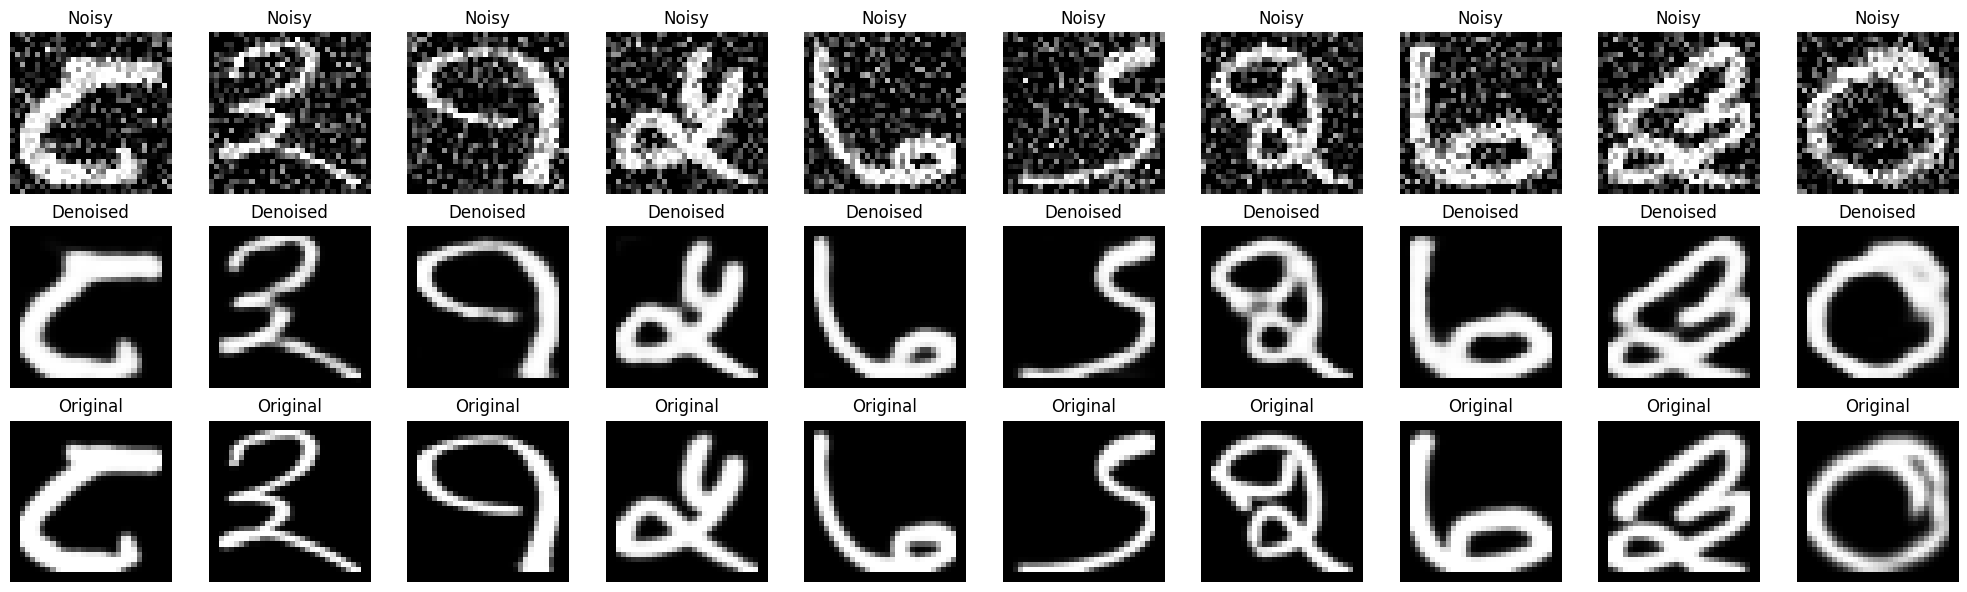

In [ ]:
decoded_imgs = autoencoder.predict(x_val)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val[i].reshape(32, 32), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised output
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_val[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()


### **Experiment and Fine Tune the Model**

Expermenting with Varied Noise Level

In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Paths
data_path = '/content/drive/MyDrive/DevanagariHandwrittenDigitDataset'
train_path = os.path.join(data_path, 'Train')
test_path = os.path.join(data_path, 'Test')

# Load images from directory
def load_images_from_folder(folder, image_size=(32, 32)):
    images = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                try:
                    img = Image.open(img_path).convert('L').resize(image_size)
                    images.append(np.array(img))
                except:
                    print(f"Error loading image: {img_path}")
    return np.array(images)

# Load train and test images
train_images = load_images_from_folder(train_path)
test_images = load_images_from_folder(test_path)

# Combine for larger training dataset
images = np.concatenate((train_images, test_images), axis=0)
images = images.astype('float32') / 255.0  # Normalize
images = np.expand_dims(images, axis=-1)  # Add channel dimension

def add_salt_and_pepper_noise(images, amount=0.05):
    noisy_images = images.copy()
    num_channels = images.shape[-1]

    for img in noisy_images:
        # Salt noise
        num_salt = np.ceil(amount * img.size * 0.5).astype(int)
        coords = [np.random.randint(0, i, num_salt) for i in img.shape[:2]]
        for c in range(num_channels):
            img[coords[0], coords[1], c] = 1

        # Pepper noise
        num_pepper = np.ceil(amount * img.size * 0.5).astype(int)
        coords = [np.random.randint(0, i, num_pepper) for i in img.shape[:2]]
        for c in range(num_channels):
            img[coords[0], coords[1], c] = 0

    return noisy_images

# Add noise BEFORE the split
noisy_images = add_salt_and_pepper_noise(images, amount=0.1)

# Train-validation split (input is noisy, target is clean)
x_train, x_val, y_train, y_val = train_test_split(noisy_images, images, test_size=0.2, random_state=42)



Using a 6-layer deep autoencoder

In [4]:
def build_deeper_autoencoder(input_shape):
    input_img = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder


In [26]:
# Compile with MSE loss and SGD optimizer
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')


In [27]:
history = autoencoder.fit(
    x_train, y_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_val, y_val)
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - loss: 0.2057 - val_loss: 0.1790
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - loss: 0.1739 - val_loss: 0.1643
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 293ms/step - loss: 0.1606 - val_loss: 0.1524
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - loss: 0.1478 - val_loss: 0.1346
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - loss: 0.1275 - val_loss: 0.1057
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - loss: 0.0980 - val_loss: 0.0781
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 330ms/step - loss: 0.0728 - val_loss: 0.0601
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 302ms/step - loss: 0.0571 - val_loss: 0.0502
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - loss: 0.0484 - val_loss: 0.0444
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - loss: 0.0433 - val_loss: 0.0406


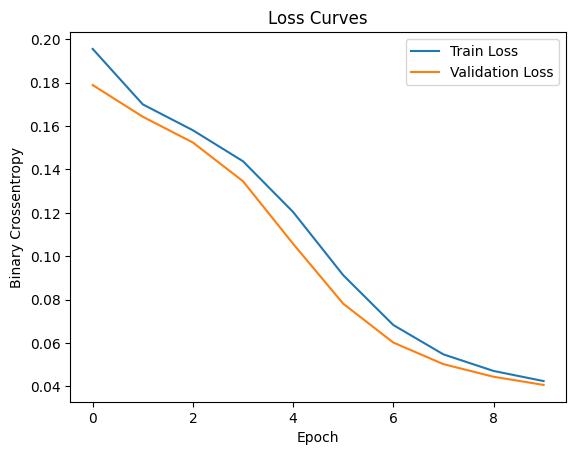

In [28]:
import matplotlib.pyplot as plt

# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.show()

Observation <br>
In this experiment, a 6-layer deep convolutional autoencoder was trained on images corrupted with salt-and-pepper noise (amount = 0.1). Unlike earlier experiments using the Adam optimizer, this setup used SGD with MSE as the loss function.Interestingly, this model achieved a lower final validation loss compared to previous salt-and-pepper experiments with Adam.